In [1]:
# Step 0. Import libraries, custom modules and logging
# Basics ---------------------------------------------------------------
import logging
import joblib
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning -----------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.metrics import (mean_squared_error, 
                             mean_absolute_error,
                             r2_score)
# Logging initialization -----------------------------------------------
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
# Step 1. Load data and get a first view -------------------------------
# 1.1 Read from source and get basic info
df_raw = pd.read_csv('skincancer.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   State   49 non-null     object 
 1   Lat     49 non-null     float64
 2   Mort    49 non-null     int64  
 3   Ocean   49 non-null     int64  
 4   Long    49 non-null     float64
dtypes: float64(2), int64(2), object(1)
memory usage: 2.0+ KB


In [3]:
# 1.2 Get a sample
display(df_raw.sample(5, random_state=2024))

,State,Lat,Mort,Ocean,Long
24,Montana,47.0,109,0,110.5
17,Maine,45.2,117,1,69.0
39,SouthDakota,44.8,86,0,100.0
26,Nevada,39.0,191,0,117.0
12,Indiana,40.2,128,0,86.2


In [4]:
# Step 2. Prepara the dataset for analysis
# 2.1 Make transformations using a pipeline
df_interim = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ','_')
        .str.replace(r'\W','',regex=True)
        .str.lower()
        .str.slice(0,40), axis=1
    )
    .rename(columns={'mort':'target'})
    .astype({'target': np.float16})
    .iloc[:,1:]
)

In [5]:
# 2.2 Create the final dataset with the target in front, show result
df = (
    df_interim
    .copy()
    .reindex(
        columns=(
            ['target'] + 
            [c for c in df_interim.columns.to_list() if c not in ['target']]
        )
    )
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  49 non-null     float16
 1   lat     49 non-null     float64
 2   ocean   49 non-null     int64  
 3   long    49 non-null     float64
dtypes: float16(1), float64(2), int64(1)
memory usage: 1.4 KB


In [6]:
# Step 3. Perform EDA
# 3.1 Split the dataset
df_train, df_test = train_test_split(df, 
                                     random_state=2024, 
                                     test_size=0.2)
df_train = df_train.reset_index(drop=True).sort_values(by='target')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, 28 to 33
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  39 non-null     float16
 1   lat     39 non-null     float64
 2   ocean   39 non-null     int64  
 3   long    39 non-null     float64
dtypes: float16(1), float64(2), int64(1)
memory usage: 1.3 KB


In [7]:
display(df_train.describe().T)

,count,mean,std,min,25%,50%,75%,max
target,39.0,156.625000,32.062500,110.0,133.0,152.0,177.50,229.0
lat,39.0,39.187179,4.629663,28.0,35.5,39.0,43.00,47.5
ocean,39.0,0.487179,0.506370,0.0,0.0,0.0,1.00,1.0
long,39.0,89.379487,14.420256,71.5,77.4,86.2,98.25,121.0


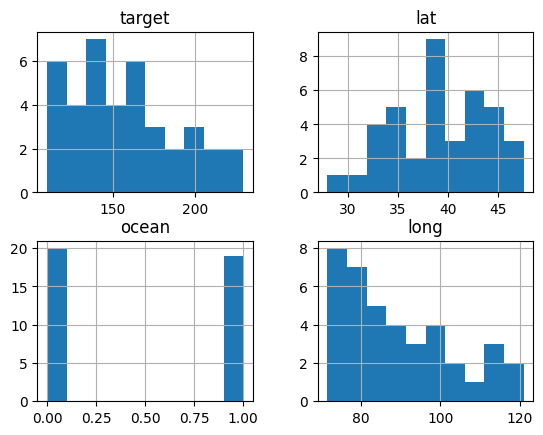

In [8]:
df_train.hist()
plt.show()

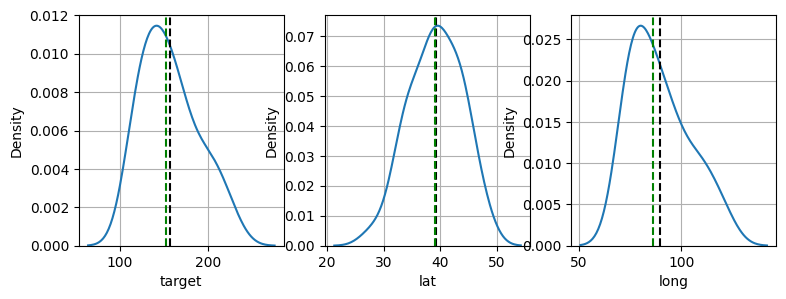

In [10]:
# 3.4 Perform univariate analysis on numerical variables using kde
fig, ax = plt.subplots(1,3, figsize=(9,3))
sns.kdeplot(data=df_train, x='target', ax=ax[0])
ax[0].axvline(x=df_train['target'].mean(), color='k', linestyle='--')
ax[0].axvline(x=df_train['target'].median(), color='g', linestyle='--')
sns.kdeplot(data=df_train, x='lat', ax=ax[1])
ax[1].axvline(x=df_train['lat'].mean(), color='k', linestyle='--')
ax[1].axvline(x=df_train['lat'].median(), color='g', linestyle='--')
sns.kdeplot(data=df_train, x='long', ax=ax[2])
ax[2].axvline(x=df_train['long'].mean(), color='k', linestyle='--')
ax[2].axvline(x=df_train['long'].median(), color='g', linestyle='--')
ax[0].grid(True)
ax[1].grid(True)
ax[2].grid(True)
plt.show()


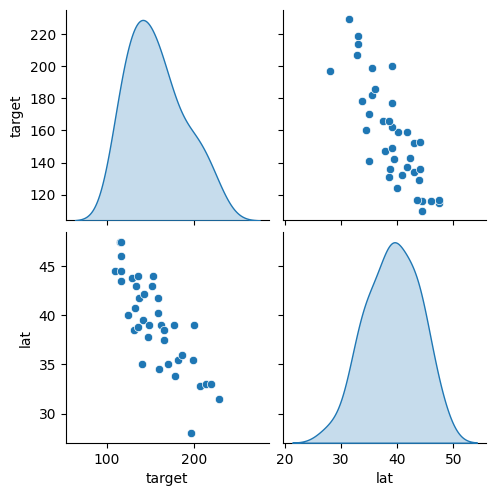

In [30]:
sns.pairplot(data=df_train, diag_kind='kde')
plt.show()

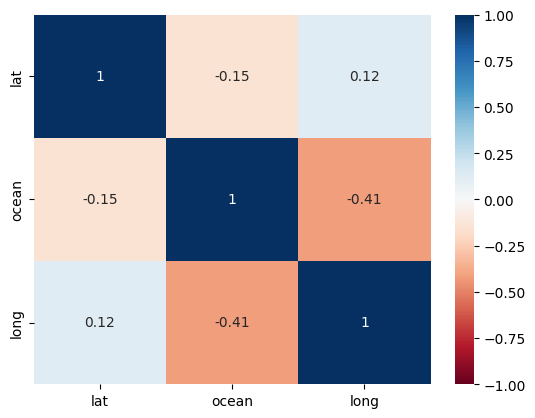

In [15]:
# 3.5 Perform correlation analysis
sns.heatmap(df_train.drop(["target"],axis=1).corr(), vmin=-1, vmax=1, annot=True, cmap='RdBu')
plt.show()



In [16]:
# Step 4. Experiment with models
# 4.1 Split features and reponse
X_train = df_train.drop('target', axis=1).reset_index(drop=True)
y_train = df_train['target'].reset_index(drop=True)
X_test = df_test.drop('target', axis=1).reset_index(drop=True)
y_test = df_test['target'].reset_index(drop=True)

In [24]:
# Modelo de regresion lineal

reg_lasso = Lasso(alpha=5)
reg_lasso.fit(X_train,y_train)
y_pred = reg_lasso.predict(X_test) 


In [25]:
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred)}')

MSE: 574.9637824269356
RMSE: 23.978402416068832
MAE: 20.654893084697576
R2: 0.5183912564272134


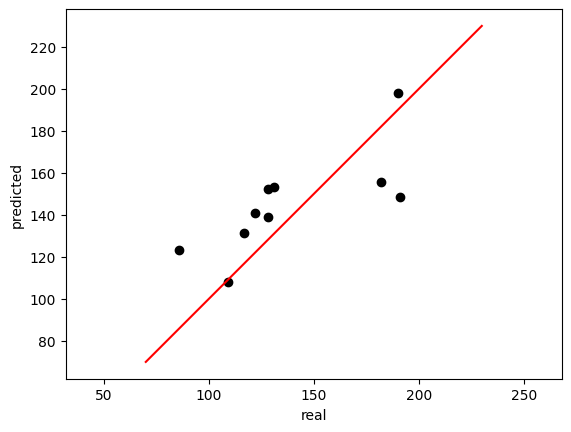

In [26]:
plt.scatter(x=y_test, y=y_pred, c='k')
plt.plot([70,230], [70,230], c='r')
plt.axis('equal')
plt.xlabel('real')
plt.ylabel('predicted')
plt.show()

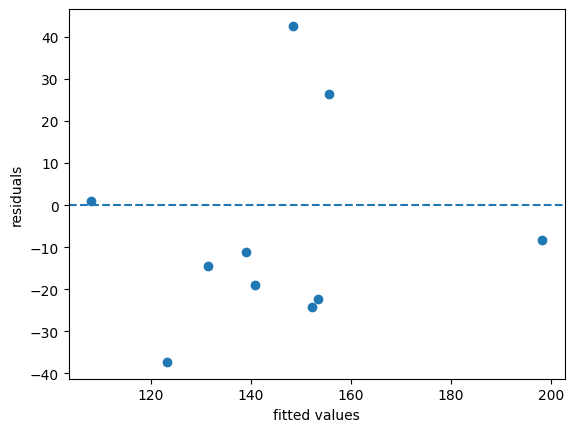

In [27]:
resid = y_test - y_pred 
plt.scatter(x=y_pred, y=resid)
plt.axhline(0, linestyle='--')
plt.xlabel('fitted values')
plt.ylabel('residuals')
plt.show()

In [29]:
print(f'mort = {reg_lasso.intercept_:.2f} {reg_lasso.coef_[0]:.2f}* lat + {reg_lasso.coef_[1]:.2f}* ocean {reg_lasso.coef_[2]:.2f}* long') #ecuacion lineal

#Utilizamos cuando quieremos eliminar variables

mort = 394.37 -5.31* lat + 0.00* ocean -0.33* long


In [30]:
# Ridgel

reg_ridge = Ridge(alpha=5)
reg_ridge.fit(X_train,y_train)
y_pred = reg_ridge.predict(X_test) 

In [31]:
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')

print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred)}')

MSE: 454.4559167855941
RMSE: 21.317971685542556
MAE: 18.04047247464874
R2: 0.6193326435823946


In [32]:
print(f'mort = {reg_ridge.intercept_:.2f} {reg_ridge.coef_[0]:.2f}* lat + {reg_ridge.coef_[1]:.2f}* ocean {reg_ridge.coef_[2]:.2f}* long') 
#Utilizamos Ridge cuando tenemos varibles muy correlacionadas y no las queremos perder 

mort = 375.45 -5.37* lat + 12.96* ocean -0.17* long


In [39]:
df_interim = (
    df_raw
    .copy()
    .set_axis(
        df_raw.columns.str.replace(' ','_')
        .str.replace(r'\W','',regex=True)
        .str.lower()
        .str.slice(0,40), axis=1
    )
    .rename(columns={'mort':'target'})
    .astype({'target': np.float16})
    .iloc[:,1:]
)

In [40]:
df = (
    df_interim
    .copy()
    .reindex(
        columns=(
            ['target'] + 
            [c for c in df_interim.columns.to_list() if c not in ['target']]
        )
    )
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  49 non-null     float16
 1   lat     49 non-null     float64
 2   ocean   49 non-null     int64  
 3   long    49 non-null     float64
dtypes: float16(1), float64(2), int64(1)
memory usage: 1.4 KB


In [41]:
df_train, df_test = train_test_split(df, 
                                     random_state=2024, 
                                     test_size=0.2)
df_train = df_train.reset_index(drop=True).sort_values(by='target')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, 28 to 33
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  39 non-null     float16
 1   lat     39 non-null     float64
 2   ocean   39 non-null     int64  
 3   long    39 non-null     float64
dtypes: float16(1), float64(2), int64(1)
memory usage: 1.3 KB


In [42]:
display(df_train.describe().T)

,count,mean,std,min,25%,50%,75%,max
target,39.0,156.625000,32.062500,110.0,133.0,152.0,177.50,229.0
lat,39.0,39.187179,4.629663,28.0,35.5,39.0,43.00,47.5
ocean,39.0,0.487179,0.506370,0.0,0.0,0.0,1.00,1.0
long,39.0,89.379487,14.420256,71.5,77.4,86.2,98.25,121.0


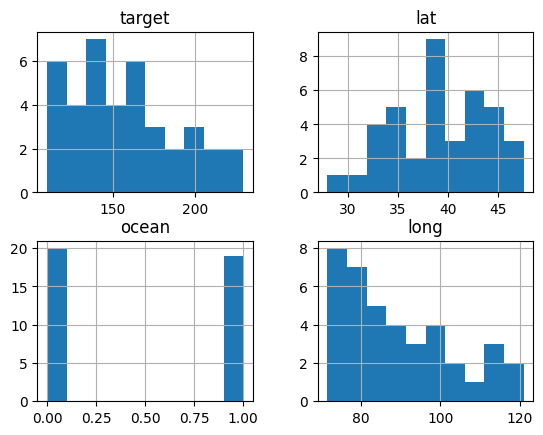

In [43]:
df_train.hist()
plt.show()

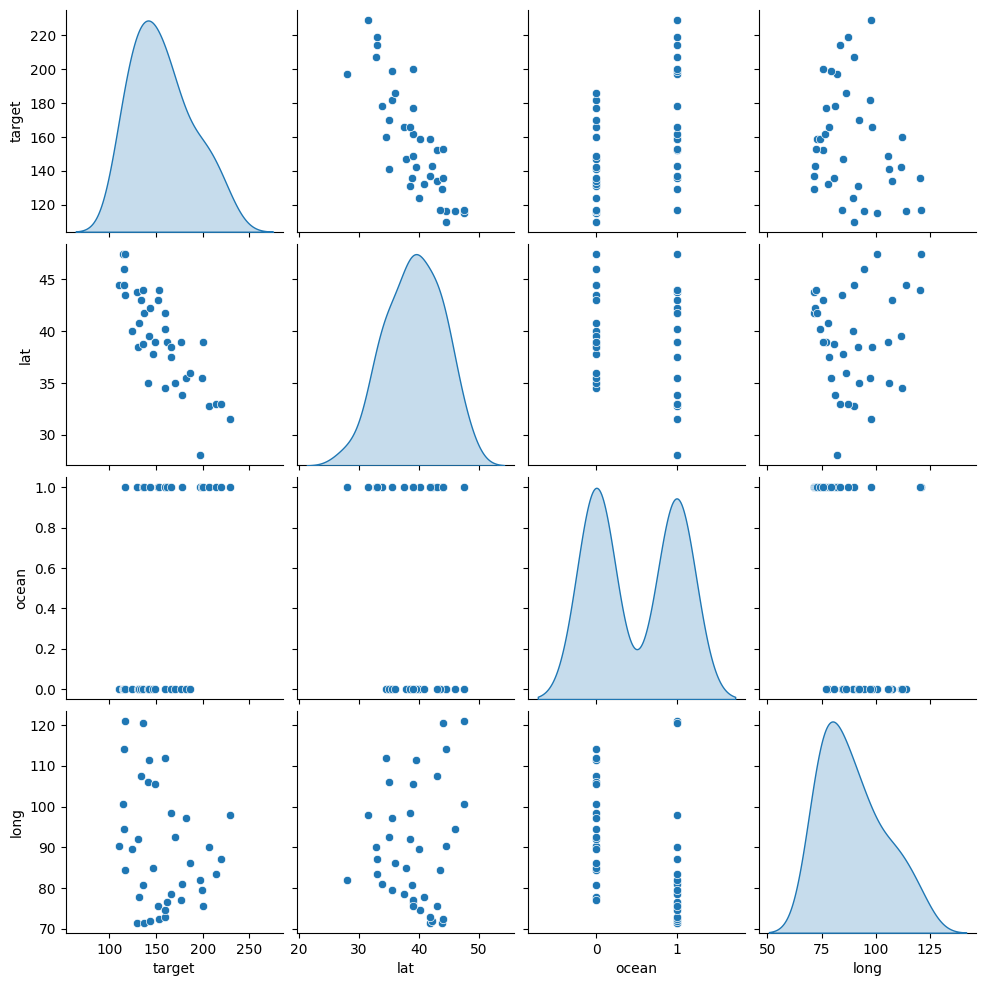

In [44]:
sns.pairplot(data=df_train, diag_kind= 'kde')
plt.show()

In [45]:
X_train = df_train.drop('target', axis=1).reset_index(drop=True)
y_train = df_train['target'].reset_index(drop=True)
X_test = df_test.drop('target', axis=1).reset_index(drop=True)
y_test = df_test['target'].reset_index(drop=True)

In [46]:
reg_mlin = LinearRegression()
reg_mlin.fit(X_train, y_train)
y_pred_m = reg_mlin.predict(X_test)

In [47]:

print(f'MSE: {mean_squared_error(y_test, y_pred_m)}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_m))}')

print(f'MAE: {mean_absolute_error(y_test, y_pred_m)}')
print(f'R2: {r2_score(y_test, y_pred_m)}')

MSE: 418.80221873805857
RMSE: 20.464657796749464
MAE: 16.358471825484738
R2: 0.6491973641877818


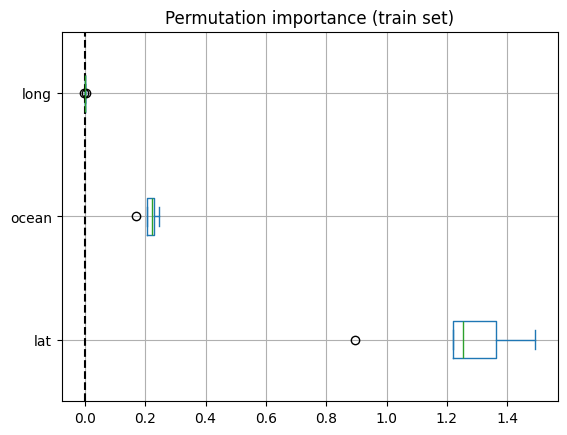

In [48]:
importance = permutation_importance(reg_mlin, X_train, y_train)
importance_df = pd.DataFrame(importance.importances.T, columns= X_train.columns)
ax = importance_df.plot.box(vert = False)
ax.axvline(x= 0, color= 'k', linestyle= '--')
ax.set_title('Permutation importance (train set)')
ax.grid(True)
plt.show()

In [49]:
print(f'mort = {reg_mlin.intercept_:.2f} {reg_mlin.coef_[0]:.2f}* lat + {reg_mlin.coef_[1]:.2f}* ocean {reg_mlin.coef_[2]:.2f}* long') 

mort = 359.00 -5.31* lat + 21.06* ocean -0.05* long
